# Import Statements

In [ ]:
!pip install folium

# Data

If you are using google drive please create a folder called "satellite_data" and place the all the data inside it as shown in the below structure


    ├── satellite_data
    |   ├── interview_area_brazil.geojson
    |   ├── features_brazil.npy






In [ ]:
import os
os.chdir("/content/drive/MyDrive/")

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from datetime import datetime
from matplotlib.patches import Rectangle
from sklearn import linear_model

# Data Preprocessing
- Choose any of the areas, brazil or canada
- Feel free to plot the images and do some data exploration
- Make sure you are comfortable with the data
- Tipp: Make sure you clip the data to values between 0 and 1, be aware of outliers

## Visualizing Brazil area and plotting it using folium

In [ ]:
# The values in the list are latitude and longitude
area_brazil = gpd.read_file('satellite_data/interview_area_brazil.geojson', driver='GeoJSON')

/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


In [46]:
map = folium.Map(location=[-9.743642694672744,-59.85483444414143], tiles="CartoDB Positron", zoom_start=10)
folium.GeoJson(
    area_brazil,
    style_function=lambda x: {'fillColor': 'cyan', 'color': 'black', 'weight': 1, 'fillOpacity': 0.5}
).add_to(map)
map

## Visualizing the area specific Brazil data

In [ ]:
brazil_data = np.load('satellite_data/features_brazil.npy')
print(brazil_data.shape) # (time, x, y, channels)

(72, 368, 420, 13)


### Making use of the RGB channels
B02, B03, B04

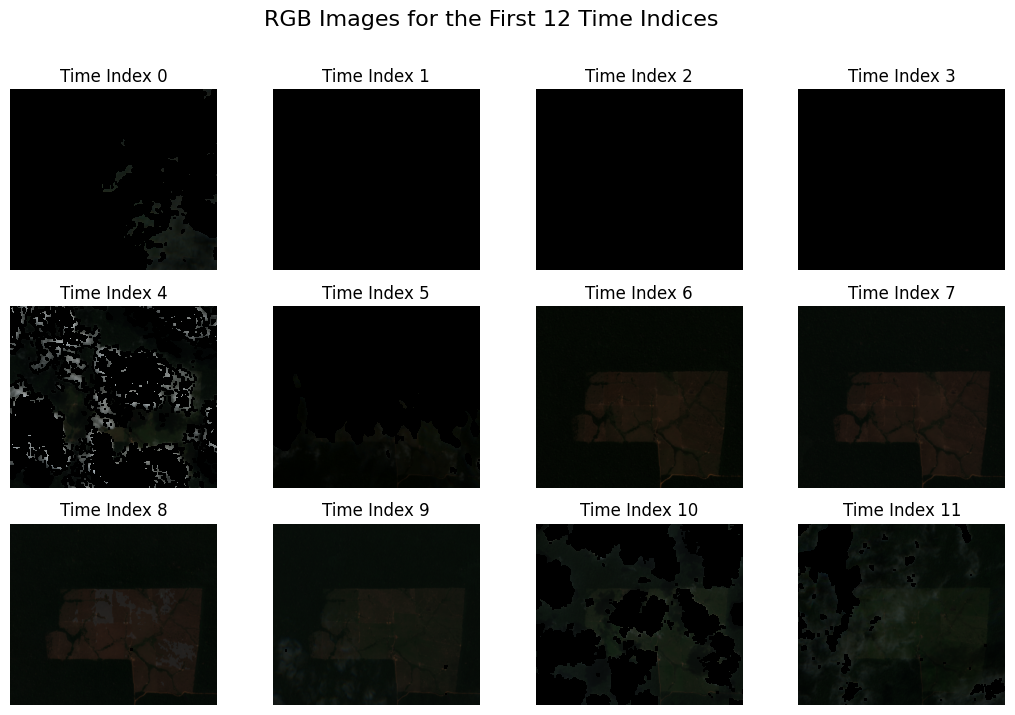

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(13, 8))
fig.suptitle("RGB Images for the First 12 Time Indices", fontsize=16)

for i in range(12):
    rgb_image = brazil_data[i, :, :, [3, 2, 1]]
    rgb_image = rgb_image.transpose((1, 2, 0))
    ax = axes[i // 4, i % 4]
    ax.imshow(rgb_image)
    ax.axis('off')
    ax.set_title(f"Time Index {i}")
plt.show()

# Learnings

## Understanding the data

1. In order to get a feel of the data first I tried inputting the lattitudes and longitudes from interview_area_brazil.geojson into https://www.gps-coordinates.net/

From this got a clear idea that the jgeojson file first we have the
-9.743642694672744 as the latitude
-59.85483444414143 as the longitude

2. In the next step I used folium (https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html) to make an interactive plot with the dummy geojson coordinates
3. Thirdly the satellite data was taken into consideration only for brazil

The tensor shape came out to be => (72, 368, 420, 13) that is time, x, y, channels respectively.
The channels are the 12 different bands of the satellite data and one quality band that indicates the quality of the image.
The bands are: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "SCL"]

# Time Series Extraction

The given data is having 13 channels so converting it into single channel

Ref: https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio

In [ ]:
# Load the data into a numpy array of shape (height, width, time, channel=1)
# There is just one band in the data because we provide a NBR time series

# (NIR - SWIR) / (NIR + SWIR)
# NBR = (Band 4 – Band 7) / (Band 4 + Band 7)
def calculate_nbr(data, band_val_1, band_val_2):
  nir = data[:, :, :, band_val_1]  # Band 4 (NIR)
  swir = data[:, :, :, band_val_2]
  nbr = (nir - swir) / (nir + swir)
  return nbr

nbr_data = calculate_nbr(brazil_data, 4, 7)
print(nbr_data.shape)

(72, 368, 420)
(420, 368, 72)


In [ ]:
# Load the data into a numpy array of shape (height, width, time, channel=1)
# Assuming the height as y, width as x
reshaped_nbr = np.transpose(nbr_data, (2, 1, 0))
print(reshaped_nbr.shape)

(420, 368, 72)


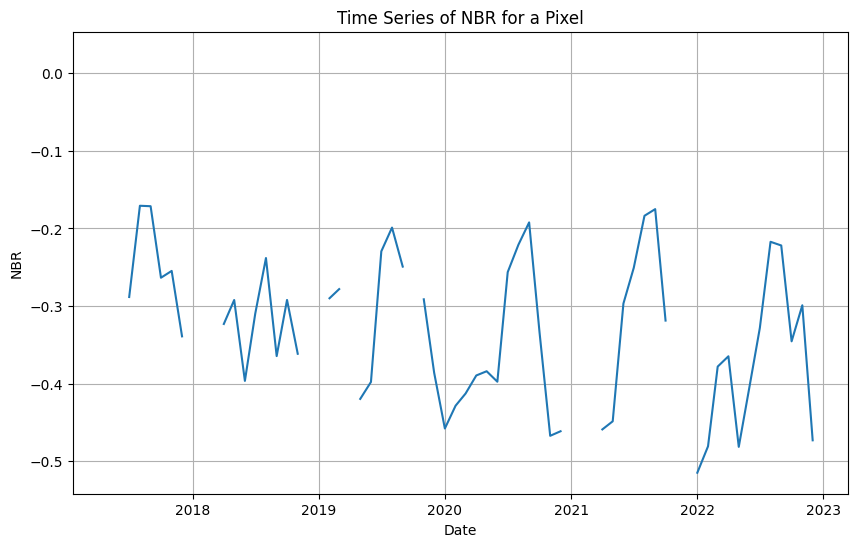

In [106]:
# Create a timeseries from the numpy ndarray by selecting an arbitrary pixel and extracting the time series
# Plot the time series

def plot_single_pixel_timeseries(data, row_index, col_index, start_date, end_date):
  pixel_timeseries = data[:, row_index, col_index]
  date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
  df = pd.DataFrame({'Date': date_range, 'NBR': pixel_timeseries})
  df.set_index('Date', inplace=True)

  # Plot the time series
  plt.figure(figsize=(10, 6))
  plt.plot(df.index, df['NBR'])
  plt.xlabel('Date')
  plt.ylabel('NBR')
  plt.title('Time Series of NBR for a Pixel')
  plt.grid(True)
  plt.show()

  return pixel_timeseries,df

row_index = 160
col_index = 215
start_date = '2017-01-01'
end_date = '2022-12-01'
pixel_timeseries,df = plot_single_pixel_timeseries(nbr_data, row_index, col_index, start_date, end_date)

# Learnings
Normalized Burn Ratio or NBR returns values between -1 and 1. Positive NBR values indicates healthy green vegetation while while burnt vegetation will have a low value. The above plot is for the pixel with the row_index = 160 and col_index = 215. When looking at the NBR for this pixel over the years we can see that in the year 2017 the value was quite closer to positive indicating greener vegetation. But the value started to decrease over the years meaning the vegetation was becoming burnt or brown vegetation or bare soil. The lowest value is recorded in the year 2022. We can see a seasonality here that is in the start of the year it is dry or brow vegetation but over the the months (mid year) it becomes greener. This shows a possiblity of rain as discussed in https://en.wikipedia.org/wiki/Climate_of_Brazil

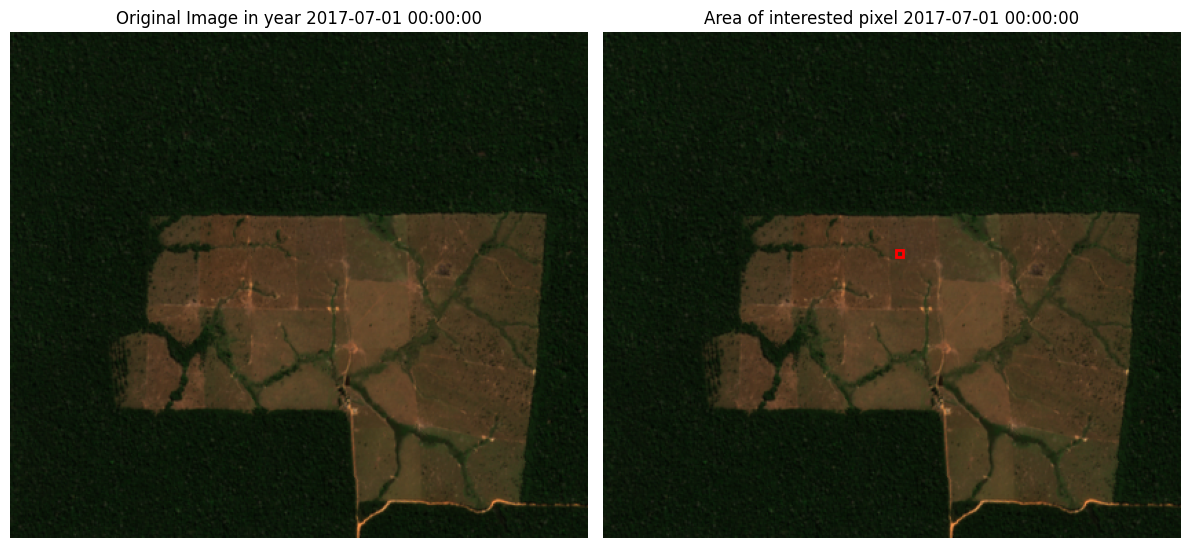

In [107]:
time_index = 6
highlight_row, highlight_col = 160, 215
# setting my square size as 5
square_size = 5

# Extract and normalize the RGB image
rgb_image = brazil_data[time_index, :, :, [3, 2, 1]]
rgb_image = rgb_image.transpose((1, 2, 0))
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plottin g original image
axes[0].imshow(rgb_image)
axes[0].axis('off')
axes[0].set_title(f"Original Image in year {df.index[time_index]}")

axes[1].imshow(rgb_image)
axes[1].axis('off')
axes[1].set_title(f"Area of interested pixel {df.index[time_index]}")
ax = axes[1]
rect = Rectangle(
    (highlight_col - square_size // 2, highlight_row - square_size // 2),
    square_size,
    square_size,
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)
plt.tight_layout()
plt.show()

# BFAST implementation
- The most relevant part of the algorithm is explained in Section 2.2. Season-trend model. (http://bfast.r-forge.r-project.org/Verbesselt+Zeileis+Herold-2012.pdf)
- Most likely, you will need to use some form of optimization to fit the parameters of the model.
- Feel free to use any optimization algorithm or package you want.
- Also feel free to make useful approximations/simplifications to the algorithm
- Make sure you choose appropiate hyperparamters - use the paper as a reference


# Fitting of BFAST to time series

References for BFAST alogorithm

1.   https://bfast.r-forge.r-project.org/
2.   https://github.com/diku-dk/bfast/tree/master

Challenges especially with BFAST

1.   BFAST algo most documentations in R
2.   pip install for BFAST algo thre an error due to package dependency between opencl and the depreciated version of numpy used (https://github.com/diku-dk/bfast/issues/40)


**The frequency for the BFAST algo is set to 12 since we have monthly data**

In [77]:
class BFASTMonitorPython():

  def __init__(self,
                start_monitor,
                freq=12,
                k=3,
                hfrac=0.25,
                trend=True,
                level=0.05,
                period=10,
                verbose=0,
                use_mp=False
                ):
      self.start_monitor = start_monitor
      self.freq = freq
      self.k = k
      self.hfrac = hfrac
      self.trend = trend
      self.level = level
      self.period = period
      self.verbose = verbose
      self.n = 0
      self._timers = {}
      self.use_mp = use_mp


  def fit_single(self, y):
          N = y.shape[0]

          # compute nan mappings
          nans = np.isnan(y)
          num_nans = np.cumsum(nans)
          val_inds = np.array(range(N))[~nans]

          # compute new limits (in data NOT containing missing values)
          # ns = n - num_nans[self.n]
          ns = self.n - num_nans[self.n - 1]
          h = int(float(ns) * self.hfrac)
          Ns = N - num_nans[N - 1]

          if ns <= 5 or Ns - ns <= 5:
              brk = -2
              mean = 0.0
              magnitude = 0.0
              if self.verbose > 1:
                  print("WARNING: Not enough observations: ns={ns}, Ns={Ns}".format(ns=ns, Ns=Ns))
              return brk, mean, magnitude, Ns

          val_inds = val_inds[ns:]
          val_inds -= self.n

          # remove nan values from patterns+targets
          X_nn = self.X[:, ~nans]
          y_nn = y[~nans]

          # split data into history and monitoring phases
          X_nn_h = X_nn[:, :ns]
          X_nn_m = X_nn[:, ns:]
          y_nn_h = y_nn[:ns]
          y_nn_m = y_nn[ns:]

          # (1) fit linear regression model for history period
          model = linear_model.LinearRegression(fit_intercept=False)
          model.fit(X_nn_h.T, y_nn_h)

          if self.verbose > 1:
              column_names = np.array(["Intercept",
                                      "trend",
                                      "harmonsin1",
                                      "harmoncos1",
                                      "harmonsin2",
                                      "harmoncos2",
                                      "harmonsin3",
                                      "harmoncos3"])
              if self.trend:
                  indxs = np.array([0, 1, 3, 5, 7, 2, 4, 6])
              else:
                  indxs = np.array([0, 2, 4, 6, 1, 3, 5])
              # print(column_names[indxs])
              print(column_names[indxs])
              print(model.coef_[indxs])

          # get predictions for all non-nan points
          y_pred = model.predict(X_nn.T)
          y_error = y_nn - y_pred

          # (2) evaluate model on monitoring period mosum_nn process
          err_cs = np.cumsum(y_error[ns - h:Ns + 1])
          mosum_nn = err_cs[h:] - err_cs[:-h]

          sigma = np.sqrt(np.sum(y_error[:ns] ** 2) / (ns - (2 + 2 * self.k)))
          mosum_nn = 1.0 / (sigma * np.sqrt(ns)) * mosum_nn

          mosum = np.repeat(np.nan, N - self.n)
          mosum[val_inds[:Ns - ns]] = mosum_nn
          if self.verbose:
              print("MOSUM process", mosum_nn.shape)

          # compute mean
          mean = np.mean(mosum_nn)

          # compute magnitude
          magnitude = np.median(y_error[ns:])

          # boundary and breaks
          a = self.mapped_indices[self.n:] / self.mapped_indices[self.n - 1].astype(np.float)
          bounds = self.lam * np.sqrt(self._log_plus(a))

          if self.verbose:
              print("lambda", self.lam)
              print("bounds", bounds)

          breaks = np.abs(mosum) > bounds
          first_break = np.where(breaks)[0]

          if first_break.shape[0] > 0:
              first_break = first_break[0]
          else:
              first_break = -1

          return first_break, mean, magnitude, Ns

In [122]:
start_monitor = datetime(2017, 1, 1)
dates = [datetime(i, j, 1) for i in range(2017, 2023) for j in range(1, 13)]
model = BFASTMonitorPython(
            start_monitor,
            freq=365,
            k=3,
            hfrac=0.25,
            trend=False,
            level=0.05,
        )
model.fit_single(pixel_timeseries)
# pixel_timeseries used which is the pixel with row_index = 160, col_index = 215
# -2 corresponds to not enough data for a pixel
# -1 corresponds to "no breaks detected"
# idx with isx>=0 corresponds to the position of the first break

(-2, 0.0, 0.0, 55)

The result for a single pixel shows insufficient data

#  Bonus: Apply BFAST to not just one, but all pixels in the area